<a href="https://colab.research.google.com/github/hjesse92/style_transfer_w266/blob/eda-base-cls/notebooks/Classification_Model_NonToxicScore_DistilBERT_512.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building NeutralScore, a classification Model for non-toxic versus toxic detection.

We'll build a classification model using Kaggle Jigsaw Toxic Classification dataset to classify if a post is non-toxic or toxic. The result of this classification model will be used as an evaluating metric for our Style Transfer model. 



## 1. Set up

In [1]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 84.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 97.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 28.4 MB/s eta 0:00:00


In [2]:
#Am I running a GPU and what type is it?
!nvidia-smi

Sun Mar 26 00:09:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    43W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torch

if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('Number of GPU(s) available:', torch.cuda.device_count())
    print('GPU device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available')
    device = torch.device("cpu")

Number of GPU(s) available: 1
GPU device name: NVIDIA A100-SXM4-40GB


In [4]:
from logging import warning
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler, TensorDataset
import torch.backends.cudnn as cudnn
import torch.optim as optim

from transformers import BertTokenizer, BertModel, DistilBertTokenizer, DistilBertModel

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import re
import random
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pprint
import os
import shutil
import time
import datetime


import warnings
warnings.filterwarnings('ignore')


In [5]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
cd drive/MyDrive/w266/style_transfer_w266/

[Errno 2] No such file or directory: 'drive/MyDrive/w266/style_transfer_w266/'
/content


## 2.EDA & Data Preprocessing

We could see that the jigsaw data split the toxic comments into different categories. For our model, we will include all of these categories into a toxic category:
 - toxic
 - severe_toxic
 - obscene
 - threat
 - insult
 - identity_hate

 Our model goal is to classify if a post is non-toxic (label = 1) versus toxic (label = 0), which could be used as a NonToxicScore metric.

In [8]:
text_file = 'drive/My Drive/data/jigsaw_classification_data.csv'
df = pd.read_csv(text_file)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [9]:
# EDA
print('Count of toxic:')
print(df.toxic.value_counts())

print('\nCount of severe toxic:')
print(df.severe_toxic.value_counts())

print('\nCount of obscene:')
print(df.obscene.value_counts())

print('\nCount of threat:')
print(df.threat.value_counts())

print('\nCount of insult:')
print(df.insult.value_counts())

print('\nCount of identity hate:')
print(df.identity_hate.value_counts())

Count of toxic:
0    144277
1     15294
Name: toxic, dtype: int64

Count of severe toxic:
0    157976
1      1595
Name: severe_toxic, dtype: int64

Count of obscene:
0    151122
1      8449
Name: obscene, dtype: int64

Count of threat:
0    159093
1       478
Name: threat, dtype: int64

Count of insult:
0    151694
1      7877
Name: insult, dtype: int64

Count of identity hate:
0    158166
1      1405
Name: identity_hate, dtype: int64


In [10]:
# Create a label column with 0 = toxic, 1 = non-toxic
df['label'] = (df.toxic + df.severe_toxic + df.obscene + df.threat + df.insult + df.identity_hate) == 0
df['label'] = df['label'].astype(int)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


In [11]:
# Count toxic & non-toxic labels 
print('\nCount of non_toxic labels:')
print(df.label.value_counts())


Count of non_toxic labels:
1    143346
0     16225
Name: label, dtype: int64


In [12]:
def modify_text_to_print(df_original, column="comment_text"):
  """Modify some toxic, offensive texts in the dataframe for printing out"""
  df = df_original.copy()
  df[column] = df[column].apply(lambda x: x.lower().replace('fuck', 'f***')\
                              .replace('shit', 's***')\
                              .replace('rape', 'r***')\
                              .replace('penis', 'p***')\
                              .replace('dick', 'd***'))

  return df

In [13]:
## Perform under_sampling to create balance the dataset
# Change majority class (non-toxic) to minority ~66%
# Change minority class (toxic) to majority ~33%
# Separate majority and minority classes
df_majority = df[df["label"] == 1]
df_minority = df[df["label"] == 0]

# Undersample majority class
df_majority_downsampled = resample(df_majority,
                                   replace=False,     # sample without replacement
                                   n_samples=round(len(df_minority)),    # change majority to minority clas
                                   random_state=42) 

# Combine minority class and downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Shuffle the rows
df_downsampled = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Count toxic & non-toxic labels for downsampled dataframe
print('\nCount of non_toxic labels:')
print(df_downsampled.label.value_counts())

modify_text_to_print(df_downsampled)


Count of non_toxic labels:
1    16225
0    16225
Name: label, dtype: int64


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label
0,736b2e14e4601fbe,we want to keep the first sentence of the lead...,0,0,0,0,0,0,1
1,7822ae6443c5e793,who cares.... goethean is a capuchin monkeys a...,1,0,0,0,0,0,0
2,838a0ed57bc52ee3,yes i would say the book source is enough to a...,0,0,0,0,0,0,1
3,accede373132c680,thanks for your help. i guess i will have to ...,0,0,0,0,0,0,1
4,a40a67134db4ea89,then do the same for the tiger accounts.,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
32445,c81e3c4002cad452,== f*** you \ni hope you die motherf***er,1,1,1,1,1,0,0
32446,47dd1a90bb3ea130,"""\n\n september 2009 \nhello, and welcome to w...",0,0,0,0,0,0,1
32447,0a760296d10de338,"welcome!\n\nhello, , and welcome to wikipedia!...",0,0,0,0,0,0,1
32448,d264b84fa1ecc882,"dear ,\n\nall three titles\n utazás faremidóba...",0,0,0,0,0,0,1


In [14]:
## Data Clean Up
def clean_up_text(x):
  """Remove line breaks, special characters, punctuations within each post"""
  # Remove special characters and punctuations
  SPECIAL_CHARS_PATTERN = re.compile(r"(\*)|(\=\=)|(\~)|(\=)|(\.\.\.)|(\;)|(\:)|(\!)|(\?)|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\%)|(\$)|(\>)|(\<)|(\{)|(\})")
  x = SPECIAL_CHARS_PATTERN.sub("", x.lower())

  # Remove different types of line breaks and white spaces
  x = re.sub(r"\n|\r|\r\n|<br\s*/?>", " ", x)
  
  # Remove extra white spaces
  x = re.sub(r"\s+", " ", x.strip())

  return x

df_downsampled["cleaned_text"] = df_downsampled.comment_text.apply(clean_up_text)
modify_text_to_print(df_downsampled[["cleaned_text", "label"]],"cleaned_text")

,cleaned_text,label
0,we want to keep the first sentence of the lead...,1
1,who cares. goethean is a capuchin monkeys anyway,0
2,yes i would say the book source is enough to a...,1
3,thanks for your help. i guess i will have to s...,1
4,then do the same for the tiger accounts.,1
...,...,...
32445,f*** you i hope you die motherf***er,0
32446,september 2009 hello and welcome to wikipedia ...,1
32447,welcome hello and welcome to wikipedia thank y...,1
32448,dear all three titles utazás faremidóba voyage...,1


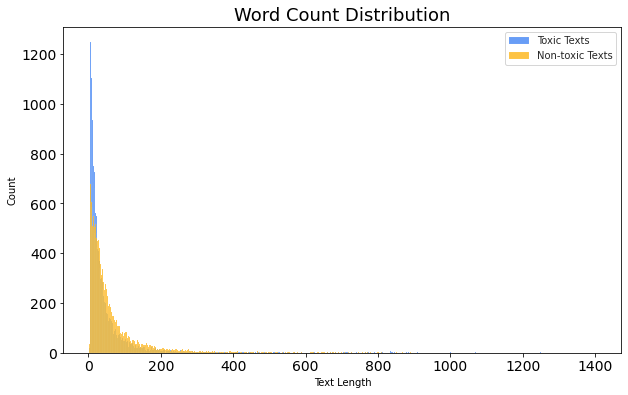

In [15]:
# Calculate word counts
df_downsampled['word_count'] = df_downsampled['cleaned_text'].apply(lambda x: len(x.split(' ')))
df_toxic = df_downsampled[df_downsampled.label == 0]
df_nontoxic = df_downsampled[df_downsampled.label == 1]

### Plot the word-count distribution for the toxic texts and the non toxic texts.
fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style('white')

# calculate the bin size based on the range of the data
bins = range(min(df_toxic['word_count'].min(), df_nontoxic['word_count'].min()), 
             max(df_toxic['word_count'].max(), df_nontoxic['word_count'].max()) + 2, 2)

# plot the histograms with the same bin size
sns.histplot(data=df_toxic, x='word_count', label='Toxic Texts', bins=bins, color='#4285F4', alpha=0.8)
sns.histplot(data=df_nontoxic, x='word_count', label='Non-toxic Texts', bins=bins, color='#FDB515', alpha=0.8)

# set the axis labels and title
ax.set(xlabel='Text Length', ylabel='Count')
ax.set_title('Word Count Distribution', fontsize=18)

# set the legend and adjust its position
plt.legend(fontsize=14)
plt.legend(loc='upper right')

# set the ticks fontsize
ax.tick_params(axis='both', which='major', labelsize=14)


In [16]:
## Train, Val, Test Split
X_full =  df_downsampled["cleaned_text"]
y_full = df_downsampled["label"]

# Split test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X_full, y_full, 
                                                            test_size=0.1,
                                                            random_state=42,
                                                            stratify=y_full
                                                            )

# Split train - dev
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                            test_size=0.12,
                                                            random_state=42,
                                                            stratify=y_train_val
                                                            )

print('Train Data Dimension:', X_train.shape)
print('Train Label Dimension:', y_train.shape)
print('Development Data Dimension:', X_val.shape)
print('Development Label Dimension:', y_val.shape)
print('Test Data Dimension:', X_test.shape)
print('Test Label Dimension:', y_test.shape)

Train Data Dimension: (25700,)
Train Label Dimension: (25700,)
Development Data Dimension: (3505,)
Development Label Dimension: (3505,)
Test Data Dimension: (3245,)
Test Label Dimension: (3245,)


In [17]:
X_full.map(len)

0         311
1          48
2          54
3         325
4          40
         ... 
32445      36
32446    1372
32447     894
32448     827
32449      96
Name: cleaned_text, Length: 32450, dtype: int64

## 3. Classification Model with DistilBERT

In [18]:
# Clear out cuda before training
torch.cuda.empty_cache()

In [19]:
# Load the BERT tokenizer
bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# From the word count distribution, most posts from the pair-wise detoxify dataset are within 32 words.
max_length = 512

train_encodings = bert_tokenizer(
    list(X_train.values), 
    max_length=max_length,
    truncation=True,
    pad_to_max_length=True, 
    return_tensors='pt'
)

valid_encodings = bert_tokenizer(
    list(X_val.values), 
    max_length=max_length,
    truncation=True,
    pad_to_max_length=True, 
    return_tensors='pt'
)

test_encodings = bert_tokenizer(
    list(X_test.values), 
    max_length=max_length,
    truncation=True,
    pad_to_max_length=True, 
    return_tensors='pt'
)

train_encodings

{'input_ids': tensor([[  101,  2019, 23615,  ...,     0,     0,     0],
        [  101,  2016,  7716,  ...,     0,     0,     0],
        [  101,  6616,  2378,  ...,     0,     0,     0],
        ...,
        [  101, 24264, 12458,  ...,     0,     0,     0],
        [  101,  7592,  1998,  ...,     0,     0,     0],
        [  101,  2115,  3566,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [20]:
## HYPER-PARAMETERS BLOCKS
BATCH_SIZE = 16
LR =2e-5
WEIGHT_DECAY = 2e-4
EPOCHS = 4
HIDDEN_SIZE = 768
DROP_OUT = 0.1
WORKERS = int(os.cpu_count())

In [21]:
## Data Loader
train_ids = train_encodings.input_ids
train_mask = train_encodings.attention_mask
train_labels = torch.tensor(y_train.values) 

val_ids = valid_encodings.input_ids
val_mask = valid_encodings.attention_mask
val_labels = torch.tensor(y_val.values)

test_ids = test_encodings.input_ids
test_mask = test_encodings.attention_mask
test_labels = torch.tensor(y_test.values)

train_dataset = TensorDataset(train_ids, train_mask, train_labels)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)

val_dataset = TensorDataset(val_ids, val_mask, val_labels)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)

test_dataset = TensorDataset(test_ids, test_mask, test_labels)
test_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)


In [22]:
# BERT Model
class BertClassification(nn.Module):
    def __init__(self,output_dim=1, hidden_size=768, dropout=0.1):
        super(BertClassification, self).__init__()
        self.bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

        self.bert_hidden_size = self.bert_model.config.hidden_size
        self.hidden_size = hidden_size
        self.hidden_layer = nn.Linear(self.bert_hidden_size, self.hidden_size)

        self.drop_out = nn.Dropout(dropout)

        self.classification = nn.Linear(self.hidden_size, output_dim)

        self.ReLU = nn.ReLU()
        self.Sigmoid = nn.Sigmoid()
        
    def forward(self, input_ids, attention_mask):
        bert_output = self.bert_model(input_ids=input_ids, 
                                      attention_mask=attention_mask)
        
        # hidden_state = bert_output[0]
        cls_token = bert_output[0][:,0]

        hidden_ouput = self.ReLU(self.hidden_layer(cls_token))
        
        hidden_ouput = self.drop_out(hidden_ouput)
        output = self.Sigmoid(self.classification(hidden_ouput))
        output = output.flatten()

        return output

In [23]:
# Initialize model
model = BertClassification(hidden_size=768, dropout=DROP_OUT)
model = model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
# Initiate loss to Binary Cross Entropy
criterion = nn.BCELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Create learning rate scheduler.
T_max = EPOCHS*len(train_loader)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)

In [25]:
def format_time(seconds):
    return str(datetime.timedelta(seconds=int(round(seconds))))

In [26]:
## Define train function
def train(train_loader, model, criterion, optimizer, verbose=True):  
    # reset total loss for each epoch
    total_loss = 0

    # switch model to train mode
    model.train()

    # start time
    t0 = time.time()

    for step, data in enumerate(train_loader):
    
        # send the data to cuda device
        ids = data[0].to(device, dtype = torch.long)
        mask = data[1].to(device, dtype = torch.long)
        # token_type_ids = data[2].to(device, dtype = torch.long)
        target = data[2].float().to(device)
    
        # compute output
        output = model(input_ids=ids, 
                      attention_mask=mask)

        # compute loss 
        loss = criterion(output, target)

        # Accumulate the training loss over all of the batches 
        total_loss += loss.item()

        # zero out gradients in the optimizer each step
        optimizer.zero_grad()

        # Report progress every 40 batches
        if step % 100 == 0 and not step == 0 and verbose==True:
            print('Batch {:>5,}  of  {:>5,}.  Loss {:0.4f}  Elapsed: {:}.'.format(
                 step, 
                 len(train_loader),
                 loss.item(),
                 format_time(time.time() - t0))) 
        
        # compute gradient and do SGD
        # backprop!
        loss.backward()
        
        # update the weights!
        optimizer.step()

        # update learning rate
        scheduler.step()

    avg_train_loss = total_loss / len(train_loader) 
    elapsed_time = time.time() - t0
    if verbose:
      print ("\nAvg Training Loss {:0.4f}, Completed in {:} \n".format(
          avg_train_loss,
          format_time(elapsed_time)
            ))
    
    # return model, avg_train_loss, elapsed_time
    return avg_train_loss, elapsed_time
 

In [27]:
## Define validate function
def validate(val_loader, model, criterion, verbose=True):
    # Initialize
    targets=[]
    outputs=[]
    t0 = time.time()
    total_val_loss = 0

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        # end = time.time()
        for step, data in enumerate(val_loader):
            
            # send the data to cuda device
            ids = data[0].to(device, dtype = torch.long)
            mask = data[1].to(device, dtype = torch.long)
            # token_type_ids = data[2].to(device, dtype = torch.long)
            target = data[2].float().to(device)

            # compute output
            output = model(input_ids=ids,
                           attention_mask=mask)

            # compute loss
            loss = criterion(output, target)

            # Accumulate the validation loss over all of the batches to calculate average loss
            total_val_loss += loss.item()

            targets.extend(target.cpu().detach().numpy().tolist())
            outputs.extend(output.cpu().detach().numpy().tolist())

            if step % 100 == 0 and not step == 0 and verbose==True:
                print('Batch {:>5,}  of  {:>5,}.  Loss {:0.4f}  Elapsed: {:}.'.format(
                    step, 
                    len(val_loader),
                    loss.item(),
                    format_time(time.time() - t0)))        

    avg_val_loss = total_val_loss / len(val_loader)
    elapsed_time = time.time() - t0
    if verbose:
      print ("\nAvg Validation Loss {:0.4f}, Completed in {:}".format(
          avg_val_loss,
          format_time(elapsed_time)
            ))
    
    return outputs, targets, avg_val_loss, elapsed_time


In [28]:
# calculate the F1 score, auc, accuracy of our predictions vs labels
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

def compute_metrics(outputs, targets):
    y_pred = (np.array(outputs) >= 0.5).astype(float)
    y_true = np.array(targets)

    # metrics
    f1 = f1_score(y_true= y_true, y_pred=y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    # accuracy = np.sum(y_pred == y_true) / len(y_true)

    print ("F1 Score {:0.4f}, ROC AUC {:0.4f}, Accuracy {:0.4f} \n".format(f1, roc_auc, accuracy))
    
    return f1, roc_auc, accuracy

In [29]:
# Store the average loss after each epoch so we can plot them.
train_loss_values = []
val_loss_values = []

for epoch in range(EPOCHS):
    print ('######  Epoch {}/{} ######'.format(epoch+1, EPOCHS))
    print ('-----  Training -----')
    train_loss, train_time = train(train_loader, model, criterion, optimizer)
    train_loss_values.append(train_loss)

    print ('-----  Validation -----')
    val_outputs, val_targets, val_loss, val_time = validate(val_loader, model, criterion)
    val_loss_values.append(val_loss)
    val_f1, val_roc_auc, val_accuracy = compute_metrics(val_outputs, val_targets)


######  Epoch 1/4 ######
-----  Training -----
Batch   100  of  1,607.  Loss 0.2403  Elapsed: 0:00:23.
Batch   200  of  1,607.  Loss 0.0310  Elapsed: 0:00:42.
Batch   300  of  1,607.  Loss 0.2799  Elapsed: 0:01:01.
Batch   400  of  1,607.  Loss 0.1870  Elapsed: 0:01:20.
Batch   500  of  1,607.  Loss 0.0539  Elapsed: 0:01:39.
Batch   600  of  1,607.  Loss 0.1033  Elapsed: 0:01:58.
Batch   700  of  1,607.  Loss 0.2623  Elapsed: 0:02:17.
Batch   800  of  1,607.  Loss 0.1042  Elapsed: 0:02:36.
Batch   900  of  1,607.  Loss 0.0288  Elapsed: 0:02:55.
Batch 1,000  of  1,607.  Loss 0.1438  Elapsed: 0:03:14.
Batch 1,100  of  1,607.  Loss 0.3749  Elapsed: 0:03:33.
Batch 1,200  of  1,607.  Loss 0.0629  Elapsed: 0:03:52.
Batch 1,300  of  1,607.  Loss 0.0963  Elapsed: 0:04:11.
Batch 1,400  of  1,607.  Loss 0.4719  Elapsed: 0:04:30.
Batch 1,500  of  1,607.  Loss 0.1424  Elapsed: 0:04:49.
Batch 1,600  of  1,607.  Loss 0.0636  Elapsed: 0:05:08.

Avg Training Loss 0.1899, Completed in 0:05:09 

-----  

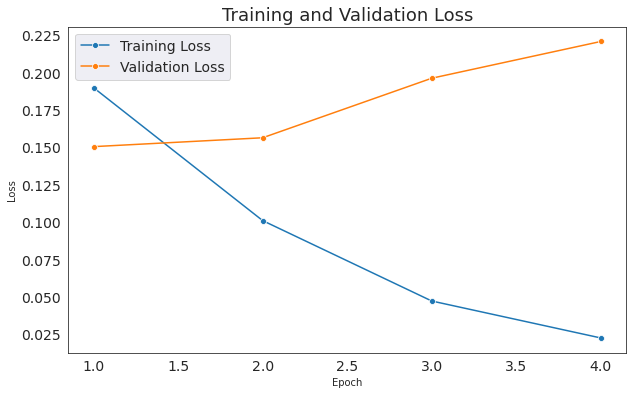

In [30]:
### Plot Training & Validation Loss
data = {'Epoch': range(1, 5), 'Training Loss': train_loss_values, 'Validation Loss': val_loss_values}
df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set(font_scale=1.5)

# Plot train & val loss
sns.lineplot(data=df, x="Epoch", y="Training Loss", label="Training Loss", marker='o')
sns.lineplot(data=df, x="Epoch", y="Validation Loss", label="Validation Loss", marker='o')

# set the axis labels and title
ax.set(xlabel='Epoch', ylabel='Loss')
ax.set_title('Training and Validation Loss', fontsize=18)

# set the legend and adjust its position
plt.legend(fontsize=14)

# set the ticks fontsize
ax.tick_params(axis='both', which='major', labelsize=14)
# ax.grid(True, which='both', linestyle='--', color='lightgray')

In [31]:
# Predicting with Test Set
test_outputs, test_targets, test_loss, test_time = validate(test_loader, model, criterion, verbose=False)
print('\nEvaluation metrics for Test Set:')
test_f1, test_roc_auc, test_accuracy = compute_metrics(test_outputs, test_targets)


Evaluation metrics for Test Set:
F1 Score 0.9430, ROC AUC 0.9432, Accuracy 0.9432 



In [32]:
# Predicting with Test Set
test_outputs, test_targets, test_loss, test_time = validate(test_loader, model, criterion, verbose=False)
print('\nEvaluation metrics for Test Set:')
test_f1, test_roc_auc, test_accuracy = compute_metrics(test_outputs, test_targets)


Evaluation metrics for Test Set:
F1 Score 0.9430, ROC AUC 0.9432, Accuracy 0.9432 



In [34]:
torch.save(model.state_dict(), 'drive/My Drive/models/DistilBertToxicClassification4.pth')

## 4. Classification Model - DistilBERT with 2 hidden layers

In [35]:
# BERT Model
class UnfreezeBertClassification(nn.Module):
    def __init__(self,output_dim=1, hidden_size=256, hidden_size2=32, dropout=0.1, unfreeze=False):
        super(UnfreezeBertClassification, self).__init__()
        self.bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # Unfreeze the last DistilBERT transformer layer
        if unfreeze:
            for name, param in self.bert_model.named_parameters():
                if 'transformer.layer.5.' in name:
                    param.requires_grad = True
                else:
                    param.requires_grad = False

        self.bert_hidden_size = self.bert_model.config.hidden_size
        self.hidden_size = hidden_size
        self.hidden_size2 = hidden_size2
        self.hidden_layer = nn.Linear(self.bert_hidden_size, self.hidden_size)
        self.hidden_layer2 = nn.Linear(self.hidden_size, self.hidden_size2)

        self.drop_out = nn.Dropout(dropout)

        self.classification = nn.Linear(self.hidden_size2, output_dim)

        self.GeLU = nn.GELU()
        self.Sigmoid = nn.Sigmoid()
        
    def forward(self, input_ids, attention_mask):
        bert_output = self.bert_model(input_ids=input_ids, 
                                      attention_mask=attention_mask)
        
        # hidden_state = bert_output[0]
        cls_token = bert_output[0][:,0]

        hidden_ouput = self.GeLU(self.hidden_layer(cls_token))
        hidden_ouput = self.drop_out(hidden_ouput)
        hidden_ouput = self.GeLU(self.hidden_layer2(hidden_ouput))
        hidden_ouput = self.drop_out(hidden_ouput)

        output = self.Sigmoid(self.classification(hidden_ouput))
        output = output.flatten()

        return output

In [36]:
HIDDEN_SIZE = 256
HIDDEN_SIZE2 = 32
DROP_OUT = 0.1
EPOCHS = 2

In [37]:
# Initialize model
unfreeze_model = UnfreezeBertClassification(hidden_size=HIDDEN_SIZE, hidden_size2=HIDDEN_SIZE2, dropout=DROP_OUT)
unfreeze_model = unfreeze_model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [38]:
# Get all of the model's parameters as a list of tuples.
params = list(unfreeze_model.named_parameters())

print('This DistilBERT model has {:} named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:4]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[4:20]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Last 15 Layer ====\n')

for p in params[-15:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

This DistilBERT model has 106 named parameters.

==== Embedding Layer ====

bert_model.embeddings.word_embeddings.weight            (30522, 768)
bert_model.embeddings.position_embeddings.weight          (512, 768)
bert_model.embeddings.LayerNorm.weight                        (768,)
bert_model.embeddings.LayerNorm.bias                          (768,)

==== First Transformer ====

bert_model.transformer.layer.0.attention.q_lin.weight     (768, 768)
bert_model.transformer.layer.0.attention.q_lin.bias           (768,)
bert_model.transformer.layer.0.attention.k_lin.weight     (768, 768)
bert_model.transformer.layer.0.attention.k_lin.bias           (768,)
bert_model.transformer.layer.0.attention.v_lin.weight     (768, 768)
bert_model.transformer.layer.0.attention.v_lin.bias           (768,)
bert_model.transformer.layer.0.attention.out_lin.weight   (768, 768)
bert_model.transformer.layer.0.attention.out_lin.bias         (768,)
bert_model.transformer.layer.0.sa_layer_norm.weight           (768

In [39]:
# Initiate loss to Binary Cross Entropy
criterion = nn.BCELoss()

# Optimizer
optimizer = optim.Adam(unfreeze_model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Create learning rate scheduler.
T_max = EPOCHS*len(train_loader)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)

In [41]:
# Store the average loss after each epoch so we can plot them.
unfreeze_train_loss_values = []
unfreeze_val_loss_values = []

for epoch in range(EPOCHS):
    print ('######  Epoch {}/{} ######'.format(epoch+1, EPOCHS))
    print ('-----  Training -----')
    unfreeze_train_loss, unfreeze_train_time = train(train_loader, unfreeze_model, criterion, optimizer)
    unfreeze_train_loss_values.append(unfreeze_train_loss)

    print ('-----  Validation -----')
    unfreeze_val_outputs, unfreeze_val_targets, unfreeze_val_loss, unfreeze_val_time = validate(val_loader, unfreeze_model, criterion)
    unfreeze_val_loss_values.append(unfreeze_val_loss)
    unfreeze_val_f1, unfreeze_val_roc_auc, unfreeze_val_accuracy = compute_metrics(unfreeze_val_outputs, unfreeze_val_targets)

######  Epoch 1/2 ######
-----  Training -----
Batch   100  of  1,607.  Loss 0.2678  Elapsed: 0:00:20.
Batch   200  of  1,607.  Loss 0.2240  Elapsed: 0:00:39.
Batch   300  of  1,607.  Loss 0.3145  Elapsed: 0:00:58.
Batch   400  of  1,607.  Loss 0.0978  Elapsed: 0:01:17.
Batch   500  of  1,607.  Loss 0.2345  Elapsed: 0:01:36.
Batch   600  of  1,607.  Loss 0.1276  Elapsed: 0:01:55.
Batch   700  of  1,607.  Loss 0.0939  Elapsed: 0:02:14.
Batch   800  of  1,607.  Loss 0.1767  Elapsed: 0:02:33.
Batch   900  of  1,607.  Loss 0.1081  Elapsed: 0:02:52.
Batch 1,000  of  1,607.  Loss 0.0738  Elapsed: 0:03:11.
Batch 1,100  of  1,607.  Loss 0.0125  Elapsed: 0:03:30.
Batch 1,200  of  1,607.  Loss 0.1539  Elapsed: 0:03:49.
Batch 1,300  of  1,607.  Loss 0.1265  Elapsed: 0:04:08.
Batch 1,400  of  1,607.  Loss 0.3252  Elapsed: 0:04:27.
Batch 1,500  of  1,607.  Loss 0.1166  Elapsed: 0:04:46.
Batch 1,600  of  1,607.  Loss 0.1952  Elapsed: 0:05:05.

Avg Training Loss 0.1844, Completed in 0:05:07 

-----  

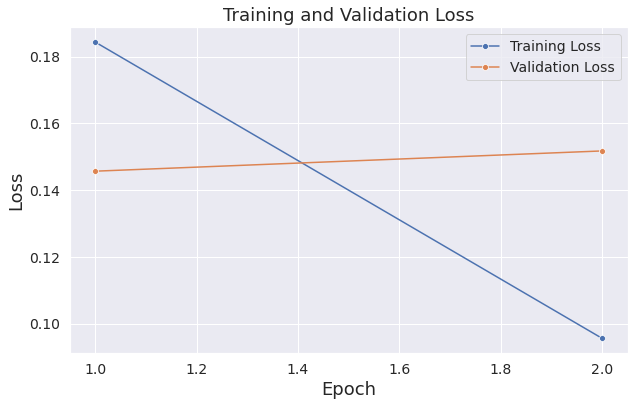

In [42]:
### Plot Training & Validation Loss
data = {'Epoch': range(1, 3), 'Training Loss': unfreeze_train_loss_values, 'Validation Loss': unfreeze_val_loss_values}
df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set(font_scale=1.5)

# Plot train & val loss
sns.lineplot(data=df, x="Epoch", y="Training Loss", label="Training Loss", marker='o')
sns.lineplot(data=df, x="Epoch", y="Validation Loss", label="Validation Loss", marker='o')

# set the axis labels and title
ax.set(xlabel='Epoch', ylabel='Loss')
ax.set_title('Training and Validation Loss', fontsize=18)

# set the legend and adjust its position
plt.legend(fontsize=14)

# set the ticks fontsize
ax.tick_params(axis='both', which='major', labelsize=14)
# ax.grid(True, which='both', linestyle='--', color='lightgray')

In [43]:
# Predicting with Test Set
unfreeze_test_outputs, unfreeze_test_targets, unfreeze_test_loss, unfreeze_test_time = validate(test_loader, unfreeze_model, criterion, verbose=False)
print('\nEvaluation metrics for Test Set:')
unfreeze_test_f1, unfreeze_test_roc_auc, unfreeze_test_accuracy = compute_metrics(unfreeze_test_outputs, unfreeze_test_targets)


Evaluation metrics for Test Set:
F1 Score 0.9462, ROC AUC 0.9464, Accuracy 0.9464 



In [44]:
torch.save(unfreeze_model.state_dict(), 'drive/My Drive/models/DistilBertToxicClassification5.pth')